In [2]:
# Code for equation numbering in markdown.
# Run this cell and then run all the markdown cells for equation numbers.
macro javascript_str(s) display("text/javascript", s); end
javascript"""
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
"""

## Problem 1

Consider reaction-diffusion equation with periodic boundary condition

$$u_t(x,t) = u_{xx}(x,t) + \varepsilon u^2,\quad x\in [0,2\pi],$$

$$u(x,0)=e^{-5(x-\pi)^2}, \quad u(0,t)=u(2\pi,t), u_x(0,t)=u_x(2\pi,t).\quad $$

Here $\varepsilon = 1.0$. Use second order finite difference discretization with uniform grid spacing $\Delta x=2\pi/100$.

Obtain the solution $u(x,T)$ at $T=6.0$ using the following methods.

a) Implement a `ForwardEuler` method, using the forward Euler for time discretization and $\Delta t=0.001$.

b) Implement a `CNBroyden` method, using a trapezoidal rule for time discretization and $\Delta t = 0.1$. This is also called the Crank-Nicolson method. Use any type of Broyden's method to solve the nonlinear equation. The starting guess for Broyden's matrix can be chosen as $B_0=\alpha I$, $\alpha=0.05$. Plot the number of iterations of Broyden's method for each step to reach certain stopping criterion (say $10^{-8}$).

Hint: the simplest version of Broyden's method to implement is the rank-1 update version with limited history of size 1.

## a) Forward Euler for reaction diffusion equation

In [3]:
using LinearAlgebra, SparseArrays, PyPlot, Statistics, Printf

function initialCondition(domain::AbstractArray)
    return exp.(-5*(domain .- pi).^2)
end

function second_derivative_operator(dx::AbstractFloat, number_of_nodes::Int64)
    A = 1.0/dx^2*spdiagm(-1 => ones(number_of_nodes-1),
        0 => -2*ones(number_of_nodes), 1 => ones(number_of_nodes-1))
    A[1,number_of_nodes] = 1/dx^2
    A[number_of_nodes,1] = 1/dx^2
    return A
end

function reactionDiffusionRHS(u::AbstractArray,
    diffusion_operator::SparseMatrixCSC)

    return diffusion_operator*u + u.^2
end

function stepForwardEuler(u::AbstractArray, diffusion_operator::SparseMatrixCSC,
    dt::AbstractFloat)

    return u + dt*reactionDiffusionRHS(u, diffusion_operator)
end

function runForwardEuler(u0::AbstractArray, dt::AbstractFloat,
    stop_time::AbstractFloat, dx::AbstractFloat, number_of_nodes::Int64)

    diffusion_operator = second_derivative_operator(dx, number_of_nodes)
    current_time = 0.0
    u = copy(u0)
    while current_time <= stop_time
        current_time += dt
        u = stepForwardEuler(u, diffusion_operator, dt)
    end
    return u
end

function plotField(domain::AbstractArray, u::AbstractArray, u0::AbstractArray;
    ylabel = "", title = "")

    fig, ax = PyPlot.subplots()
    ax.plot(domain, u, label = "Numerical solution")
    ax.plot(domain, u0, "--", label = "Initial condition")
    ax.legend()
    ax.set_xlabel(L"x")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid()
end

plotField (generic function with 1 method)

## Solve Forward Euler with $\Delta t = 0.001$

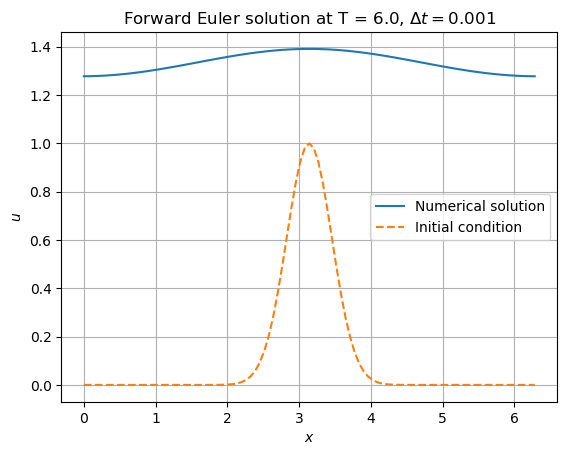

In [4]:
number_of_nodes = 101
stop_time = 6.0
dt = 0.001
dx = 2pi/(number_of_nodes-1)
diffusion_operator = second_derivative_operator(dx, number_of_nodes)
domain = range(0.0, stop = 2pi, length = number_of_nodes)
u0 = initialCondition(domain)
u = runForwardEuler(u0, dt, stop_time, dx, number_of_nodes)
plotField(domain, u, u0, ylabel = L"u", title = L"Forward Euler solution at T = 6.0, $\Delta t = 0.001$")

## b) Trapezoidal Rule with Broyden's method

In [5]:
function broydenLagrangeMultiplier(Bprev::Matrix, y::AbstractArray, s::AbstractArray)
    return (Bprev*y - s)/dot(y,y)
end

function updateBroydenMatrix(Bprev::Matrix, y::AbstractArray, s::AbstractArray)
    lambda = broydenLagrangeMultiplier(Bprev, y, s)
    return Bprev - lambda*y'
end

function trapezoidNonlinearFunction(unext::AbstractArray, uprev::AbstractArray,
    diffusion_operator::SparseMatrixCSC, dt::AbstractFloat)

    Fprev = reactionDiffusionRHS(uprev, diffusion_operator)
    Fnext = reactionDiffusionRHS(unext, diffusion_operator)
    return unext - uprev - dt/2*(Fprev + Fnext)
end

function iterateBroyden(u_previous_timestep::AbstractArray,
    diffusion_operator::SparseMatrixCSC, broydenMatrix::Matrix,
    dt::AbstractFloat; tol = 1e-8, maxiter = 100)

    uprev = copy(u_previous_timestep)
    unext = copy(uprev)
    count = 0
    Fprev = trapezoidNonlinearFunction(uprev, u_previous_timestep,
        diffusion_operator, dt)
    Fnext = copy(Fprev)

    while norm(Fnext) > tol && count < maxiter
        unext = uprev - broydenMatrix*Fprev
        Fnext = trapezoidNonlinearFunction(unext, u_previous_timestep,
            diffusion_operator, dt)
        s = unext - uprev
        y = Fnext - Fprev
        broydenMatrix = updateBroydenMatrix(broydenMatrix, y, s)
        Fprev = Fnext
        uprev = unext
        count += 1
    end
    if count == maxiter
        error("Broyden iterations failed to converge in $maxiter iterations")
    end
    return unext, broydenMatrix, count
end

function runTrapezoidal(u0::AbstractArray, dt::AbstractFloat,
    stop_time::AbstractFloat, dx::AbstractFloat, number_of_nodes::Int64;
    alpha = 0.05)

    diffusion_operator = second_derivative_operator(dx, number_of_nodes)
    current_time = 0.0
    u = copy(u0)
    broydenMatrix = alpha*Matrix(1.0*I, number_of_nodes, number_of_nodes)
    num_broyden_iterations = Int[]
    while current_time <= stop_time
        current_time += dt
        u, broydenMatrix, count = iterateBroyden(u, diffusion_operator, broydenMatrix, dt)
        push!(num_broyden_iterations, count)
    end
    return u, num_broyden_iterations
end

function plotIterations(num_iterations::AbstractArray; ylabel = "", title = "")
    fig, ax = PyPlot.subplots()
    ax.plot(num_iterations, "-o")
    ax.set_xlabel("Time steps")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid()
end

plotIterations (generic function with 1 method)

## Solve Trapezoidal rule with $\Delta t = 0.1$

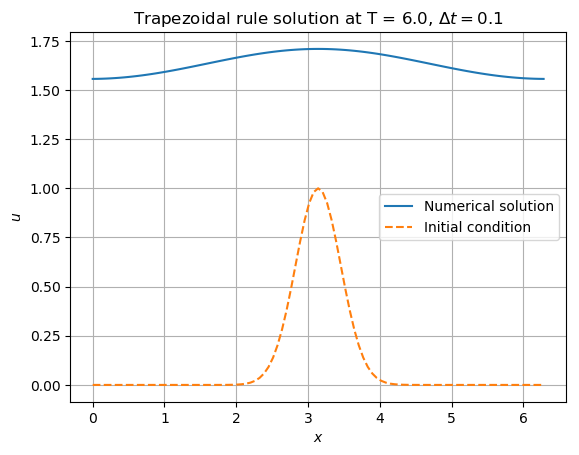

In [6]:
number_of_nodes = 101
stop_time = 6.0
dt = 0.1
dx = 2pi/(number_of_nodes-1)
domain = range(0.0, stop = 2pi, length = number_of_nodes)
u0 = initialCondition(domain)
diffusion_operator = second_derivative_operator(dx, number_of_nodes)

u, num_broyden_iterations = runTrapezoidal(u0, dt, stop_time, dx, number_of_nodes)
plotField(domain, u, u0, ylabel = L"u", title = L"Trapezoidal rule solution at T = 6.0, $\Delta t = 0.1$")

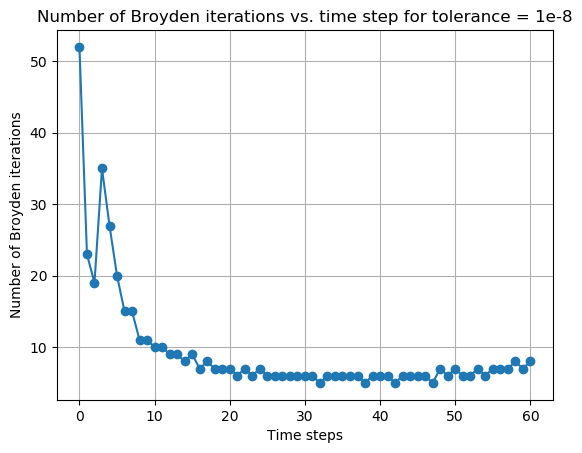

In [7]:
fig = plotIterations(num_broyden_iterations, ylabel = "Number of Broyden iterations", 
    title = "Number of Broyden iterations vs. time step for tolerance = 1e-8")


## Problem 2

Use the five-point finite difference formula and solve 

$$-\Delta u(x,y) = 1, \quad u\vert_{\partial \Omega} = 0,$$

on a $L$-shaped domain (see below, blue shaded region)

$$\Omega=((0,1)\times(0,1)) \backslash ([1/2,1]\times[1/2,1]).$$

Use a grid spacing $h=1/(N+1)$ and $N=200$. 

1) Write a function `FDLshape` which returns $X,Y,U$, so that $U_{i,j}$ is the approximate solution for $u(X[i,j],Y[i,j])$. If $(X[i,j],Y[i,j])$ is not in $\Omega$, $U_{i,j}=0$. Plot the solution $U$. You can solve the equation using the backslash directly.

2) Write a function `FDLshapeCG` which does the same job, but uses the conjugate gradient solver to solve the linear system and get the same result. You should write your own CG solver instead of using external packages.

This is how you obtain (something close to) MATLAB's logo!

https://www.mathworks.com/company/newsletters/articles/the-mathworks-logo-is-an-eigenfunction-of-the-wave-equation.html

## 1) Poisson equation on L-shaped domain with direct solution of the linear system

In [8]:
function ndgrid(v1::AbstractVector{T}, v2::AbstractVector{T}) where T
    m, n = length(v1), length(v2)
    v1 = reshape(v1, m, 1)
    v2 = reshape(v2, 1, n)
    (repeat(v1, 1, n), repeat(v2, m, 1))
end

function constructDomain(number_of_nodes::Int64)
    dx = 1.0/(number_of_nodes - 1)
    @assert isinteger((number_of_nodes-1)*0.5) "Require grid size such that 0.5/h is integer, got $dx"
    domain_x = 0.0:dx:1.0
    X, Y = ndgrid(domain_x, domain_x)
    return X, Y
end

function inCutOut(I::Int64, J::Int64, M::Int64)
    if I >= M && J >= M
        return true
    else
        return false
    end
end

function onBoundary(I::Int64, J::Int64, nx::Int64)
    if I == 1 || I == nx || J == 1 || J == nx
        return true
    else
        return false
    end
end

function mask(nx::Int64)
    mid = round(Int,(nx+1)/2)
    U = zeros(nx,nx)
    for j in 1:nx
        for i in 1:nx
            U[i,j] = inCutOut(i,j,mid) || onBoundary(i,j,nx) ? 0.0 : 1.0
        end
    end
    return U
end

function indexToDOF(I::Int64, J::Int64, nx::Int64)
    return (I-1)*nx + J
end


function poissonOperator(nx::Int64, dx::AbstractFloat)
    rows = Int64[]
    cols = Int64[]
    vals = Float64[]
    ndofs = nx*nx
    stencil = -[1.0, 1.0, -4.0, 1.0, 1.0]/dx^2
    mid = round(Int,(nx+1)/2)
    for I in 1:nx
        for J in 1:nx
            current_dof = indexToDOF(I, J, nx)
            if inCutOut(I, J, mid) || onBoundary(I, J, nx)
                append!(rows, current_dof)
                append!(cols, current_dof)
                append!(vals, 1.0)
            else
                append!(rows, repeat([current_dof], 5))
                right = indexToDOF(I, J+1, nx)
                left = indexToDOF(I, J-1, nx)
                top = indexToDOF(I+1, J, nx)
                down = indexToDOF(I-1, J, nx)
                append!(cols, [right, left, current_dof, top, down])
                append!(vals, stencil)
            end
        end
    end
    A = sparse(rows, cols, vals, ndofs, ndofs)
    return A
end

function poissonRHS(nx::Int64, dx::AbstractFloat)
    ndofs = nx*nx
    rhs = zeros(ndofs)
    mid = round(Int,(nx+1)/2)
    for I in 1:nx
        for J in 1:nx
            current_dof = indexToDOF(I, J, nx)
            if inCutOut(I, J, mid) || onBoundary(I, J, nx)
                rhs[current_dof] = 0.0
            else
                rhs[current_dof] = 1.0
            end
        end
    end
    rhs
end

function plot_solution(solution, number_of_nodes)
    U = reshape(solution, number_of_nodes, number_of_nodes)
    X, Y = constructDomain(number_of_nodes)
    fig, ax = PyPlot.subplots()
    cb = ax.contourf(X,Y,U)
    fig.colorbar(cb)
end

plot_solution (generic function with 1 method)

## Solve with $N = 200$ with direct solver

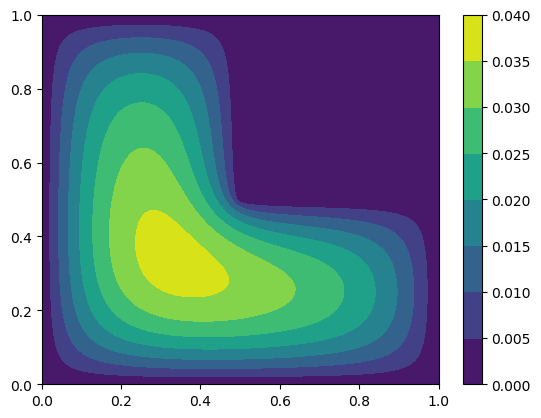

PyObject <matplotlib.colorbar.Colorbar object at 0x1454cf6a0>

In [9]:
number_of_nodes = 201
dx = 1.0/(number_of_nodes-1)
A = poissonOperator(number_of_nodes, dx)
rhs = poissonRHS(number_of_nodes, dx)
U = A\rhs
plot_solution(U, number_of_nodes)

## Poisson equation on L-shaped domain with conjugate gradient solver

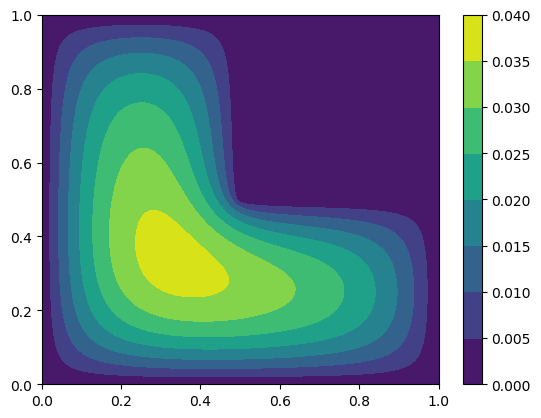

PyObject <matplotlib.colorbar.Colorbar object at 0x1434d5c18>

In [10]:
function solveEfficientCG(A::SparseMatrixCSC, rhs::AbstractArray; tol = 1e-8)
    ndofs = length(rhs)
    solution = copy(rhs)
    residual = rhs - A*solution
    update_direction = copy(residual)
    count = 0
    while norm(residual) > tol && count <= ndofs

        Ap0 = A*update_direction
        p0Ap0 = update_direction'*Ap0

        alpha = update_direction'*residual/(p0Ap0)
        solution += alpha*update_direction

        residual -= alpha*Ap0
        beta = residual'*Ap0/p0Ap0

        update_direction *= beta
        update_direction += residual

        count += 1
    end
    if count == ndofs
        error("CG failed to converge in $ndofs iterations")
    end
    return solution, count
end


UCG, count_effCG = solveEfficientCG(A, rhs)
plot_solution(UCG, number_of_nodes)

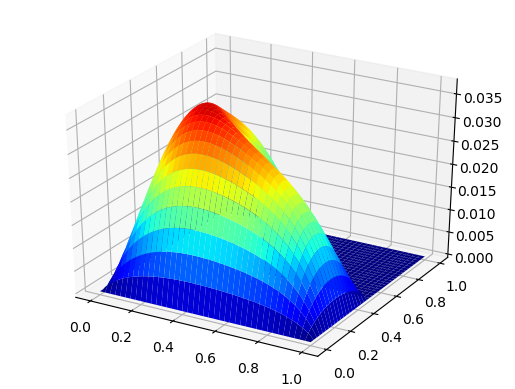

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x144e85ba8>

In [11]:
X, Y = constructDomain(number_of_nodes)
Z = reshape(UCG, number_of_nodes, number_of_nodes)
plot_surface(X,Y,Z,cmap=ColorMap("jet"), vmin = 0.0, vmax = 0.04)

## Problem 3

Consider a matrix $A\in \mathbb{R}^{N\times N}$. $A$ is diagonalizable with only two distinct eigenvalues $\pm 1$. Prove that for any right hand side $b$ and initial guess $x_0$, GMRES solves the equation $Ax=b$ with at most 2 iterations.

## Solution

If $A$ is diagonalizable, then there exists a basis of $\mathbb{R}^N$ that is composed entirely of eigenvectors of $A$. Let $g_1, g_2, \ldots g_p$ be the eigenvectors of $A$ with eigenvalue $+1$ and $h_1, h_2, \ldots h_s$ be the eigenvectors with eigenvalues $-1$ such that $p+s = N$ and the set $B = \{g_1, \ldots g_p, h_1, \ldots h_s \}$ forms a basis of $\mathbb{R}^N$.

Now consider the initial residual $r_0 = b - Ax_0$ for some guess $x_0$. Following the procedure of the Arnoldi iteration, we first compute $v_0 = r_0 / ||r_0||$. We now write $v_0$ in terms of the basis $B$ as,

\begin{align*}
v_0 = \sum_{i=1}^p \alpha^0_i g_i + \sum_{j=1}^s \beta^0_j h_j
\end{align*}

for some coefficients $\alpha^0_i, \beta^0_j$. Define vectors $G$ and $H$ as,

\begin{align}
\begin{aligned}
G := \sum_{i=1}^p \alpha^0_i g_i \\
H := \sum_{j=1}^s \beta^0_j h_j
\end{aligned} \label{eq:lin-combination-basis}
\end{align}

Further, because $G$ and $H$ are linear combinations of eigenvectors with eigenvalue $+1$ and $-1$ respectively, we have,

\begin{align}
\begin{aligned}
AG &= G \\
AH &= -H
\end{aligned} \label{eq:AG-AH}
\end{align}

Now we compute $Av_0$ as,

\begin{align*}
A v_0 &= AG + AH \\
&= G - H
\end{align*}

Similarly we compute $A^2 v_0$ as,

\begin{align}
A^2 v_0 = AAv_0 &= AG - AH \nonumber \\
&= G + H \nonumber \\
\implies A^2 v_0 &= v_0 \label{eq:A2v0}
\end{align}

The next orthonormal basis of the Krylov sub-space is computed as,

\begin{align}
\tilde{v_1} &= Av_0 - \gamma_0 v_0 \qquad \mathrm{such \ that, \ } \tilde{v_1}^T v_0 = 0 \nonumber \\ 
&= G - H - \gamma_0 (G + H) \nonumber \\
\tilde{v_1} &= (1 - \gamma_0) G - (1 + \gamma_0) H \nonumber \\
\implies v_1 &= \frac{\tilde{v_1}}{||\tilde{v_1}||} = \alpha^1 G + \beta^1 H \label{eq:v1}
\end{align}

for some coefficients $\alpha^1, \beta^1$.

Similarly, the next orthonormal basis of the Krylov sub-space is computed as,

\begin{align}
\tilde{v_2} &= Av_1 - \gamma_1 v_1 - \gamma_0 v_0 \nonumber \qquad \mathrm{such \ that, \ } \tilde{v_2}^T v_1 = 0 \\
&= \alpha^1 AG + \beta^1 AH - \gamma_1 (\alpha^1 G + \beta^1 H) - \gamma_0 (G + H) \nonumber \\
&= (\alpha^1 - \gamma_1 \alpha^1 - \gamma^0) G + (\beta^1 - \gamma^1 \beta^1 - \gamma^0) H \nonumber \\
\implies v_2 &= \frac{\tilde{v_2}}{|| \tilde{v_2} ||} = \alpha^2 G + \beta^2 H \label{eq:v2}
\end{align}

For some coefficients $\alpha^2, \beta^2$.

Now we have the following:

$v_0, v_1, v_2$ are part of an orthonormal basis of the Krylov sub-space. However, $v_0, v_1, v_2$ are all represented as linear combinations of the vectors $G, H$. Thus, this can only be possible if one of $v_0, v_1, v_2$ is the zero vector.

### Case 1: If $v_0 = 0$
This means that the initial residual is $0$, i.e. $Ax_0 = b$ and the linear system was already solved by the guess.

### Case 2: If $v_1$ or $v_2$ are $0$

By Proposition 6.6 of Iterative Methods for Sparse Linear Systems, Yousef Saad, the projection method onto the Krylov sub-space is exact if one of the orthonormal basis constructed by the Arnoldi procedure becomes the zero vector. This means that the true solution can in fact be perfectly represented by linear combinations of the orthonormal basis constructed up to this point. Thus, GMRES will obtain the correct solution in at most two iterations.

## Problem 4

The nonlinear Schrodinger equation in 1D

$$\imath \partial_t u(x,t) = -\partial_{xx} u(x,t)+\beta \vert u(x,t)\vert^2 u(x,t), \quad x\in \mathbb{R}$$

has an exact solution  

$$\psi_{exact}(x,t) = \frac{2a}{\beta} \text{sech}\left[\sqrt{a}(x-x_0-ct)\right] \exp\left[\imath \frac{c}{2}(x-x_0)-\imath\left(\frac{c^2}{4}-a\right)t\right].$$

Here we choose the parameter

$\beta=-8.0,a=\beta^2/16,c=0.5,x_0=-3.0$.


Solve this problem on a finite sized domain $[-L/2,L/2]$ with $L=20$ and periodic boundary condition. Use the central finite difference scheme for spatial discretization. 

(1) Write a routine `rk4` to compute the solution at $T_f=1.0$ using the RK4 method. You need to choose the grid size (spatial and temporal) so that the maximum absolute error of the solution (by comparing to the exact solution) is less than $10^{-3}$.

(2) Write a routine `IMEX` to do the same thing with the IMEX method, where the implicit scheme is chosen to be the trapezoidal rule, and the explicit scheme is AB2.  If there is a linear system to be solved, use GMRES to solve the linear system.

You should write your own GMRES solver instead of using external packages. The solution of reduced linear system should use the efficient implementation based on Given rotation.

see, e.g.

https://www.math.ucla.edu/~jteran/270c.1.11s/notes_wk2.pdf

or

Y. Saad, Iterative methods for sparse linear systems, SIAM, 2003; Chap 6.5

## Solution by RK4 method

In [12]:
function analyticalSolution(x, t)
    return 2.0*a/β * sech(sqrt(a)*(x-x0-c*t)) * exp(im*(c/2.0*(x-x0)-(c^2/4.0-a)*t))
end

function periodicLaplacian(hs, Ns)
    laplacian = 1.0/hs^2 * spdiagm(-1=> ones(Ns-1),0=> -2.0*ones(Ns),1=> ones(Ns-1))
    return laplacian
end

function nonlinearSchrodingerRHS(u::Vector)
    return -im*β*((norm.(u)).^2).*u
end

function schrodingerRHS(u::Vector, laplacian::SparseMatrixCSC)
    return im*laplacian*u + nonlinearSchrodingerRHS(u)
end

function rk4Stages(solution::Vector, laplacian::SparseMatrixCSC,
    step_size::AbstractFloat)

    k1 = schrodingerRHS(solution, laplacian)
    k2 = schrodingerRHS(solution+step_size/2*k1, laplacian)
    k3 = schrodingerRHS(solution+step_size/2*k2, laplacian)
    k4 = schrodingerRHS(solution+step_size*k3, laplacian)
    return k1, k2, k3, k4
end

function stepRK4(solution::Vector, laplacian::SparseMatrixCSC,
    step_size::AbstractFloat)

    k1, k2, k3, k4 = rk4Stages(solution, laplacian, step_size)
    return solution + step_size/6*(k1+2k2+2k3+k4)
end

function runStepsRK4(solution0::Vector, laplacian::SparseMatrixCSC,
    step_size::AbstractFloat, stop_time::AbstractFloat)

    ndofs = length(solution0)
    solution = copy(solution0)
    current_time = 0.0
    while current_time < stop_time
        solution = stepRK4(solution, laplacian, step_size)
        current_time += step_size
    end
    return solution
end

function computeError(u_numeric, u_analytic)
    return maximum(abs.(u_numeric - u_analytic))
end

computeError (generic function with 1 method)

## Run RK4 iterations to get maximum absolute error $< 10^{-3}$

In [13]:
const L = 20.0
stop_time = 1.0
const β = -8.0
const a = β^2/16.0
const c = 0.5
const x0 = -3.0

number_of_nodes = 1500
dx = L/(number_of_nodes - 1)
dt_rk4 = 1e-4

domain = range(-L/2, stop = L/2, length = number_of_nodes)

initial_condition = analyticalSolution.(domain,0.0)
analytical_solution = analyticalSolution.(domain,stop_time)
laplacian = periodicLaplacian(dx, number_of_nodes)
rk4_solution = runStepsRK4(initial_condition, laplacian, dt_rk4, stop_time);

In [14]:
err = @sprintf "%1.3e" computeError(rk4_solution, analytical_solution)
println("Max error RK4  = ", err)

Max error RK4  = 9.994e-04


## Solution by IMEX method -- Trapezoidal Rule + AB2
### Linear system solved by GMRES with Givens rotation for QR factorization

In [17]:
function givensCoefficients(sub_diagonal_entry::Complex, diagonal_entry::Complex)
    s0 = conj(sub_diagonal_entry)
    c0 = conj(diagonal_entry)
    magnitude = sqrt(norm(c0)^2 + norm(s0)^2)
    c = c0/magnitude
    s = s0/magnitude
    return c, s
end

function updateRows(matrix::Matrix, cosine::Complex, sine::Complex, row)
    num_rows, num_cols = size(matrix)
    for col in 1:num_cols
        upper_row_val = matrix[row,col]
        lower_row_val = matrix[row+1,col]
        matrix[row,col] = upper_row_val*cosine + lower_row_val*sine
        matrix[row+1,col] = -upper_row_val*conj(sine) + lower_row_val*conj(cosine)
    end
end

function updateRows(rhs::Vector, cosine::Complex, sine::Complex, row)
    upper_row_val = rhs[row]
    lower_row_val = rhs[row+1]

    rhs[row] = upper_row_val*cosine + lower_row_val*sine
    rhs[row+1] = -upper_row_val*conj(sine) + lower_row_val*conj(cosine)
end

function solveRow(A::Matrix, solution::Vector{ComplexF64}, rhs::Vector{ComplexF64}, row, num_cols)
        solution[row] = (rhs[row] -
                     sum(A[row,row+1:num_cols] .* solution[row+1:num_cols]))/A[row,row]
end

function backSolve(A::Matrix, rhs::Array{ComplexF64, 1})
    num_rows, num_cols = size(A)
    solution = zeros(ComplexF64, num_cols)
    solution[num_cols] = rhs[num_cols]/A[num_cols,num_cols]
    for i in 1:num_cols - 1
        row = num_cols - i
        solveRow(A,solution,rhs,row,num_cols)
    end
    return solution
end

function givensQR!(matrix::Matrix, rhs::Vector)
    num_rows, num_cols = size(matrix)
    @assert (num_rows == num_cols + 1) "Matrix dimensionality must by (m+1,m), got ($num_rows,$num_cols)"
    for col in 1:num_cols
        diagonal_entry = matrix[col,col]
        sub_diagonal_entry = matrix[col+1,col]
        cosine, sine = givensCoefficients(sub_diagonal_entry, diagonal_entry)
        updateRows(matrix, cosine, sine, col)
        updateRows(rhs, cosine, sine, col)
    end
    residual = abs(rhs[num_rows])
    return residual
end

function solveGivensQR(A,rhs)
    givensQR!(A,rhs)
    return backSolve(A,rhs)
end

function arnoldi(A::SparseMatrixCSC, v::Vector{T}, m) where T
    rows, cols = size(A)
    orthonormal_vectors = zeros(T, rows, m+1)
    hessenberg_matrix = zeros(T, m+1,m)
    orthonormal_vectors[:,1] = v/norm(v)
    for j in 1:m
        vj = orthonormal_vectors[:,j]
        wj = A*vj
        for i in 1:j
            vi = orthonormal_vectors[:,i]
            hij = dot(vi,wj)
            wj = wj - hij*vi
            hessenberg_matrix[i,j] = hij
        end
        h = norm(wj)
        if isapprox(h,0.0, atol = 1e-15)
            m = j
            break
        end
        hessenberg_matrix[j+1,j] = h
        orthonormal_vectors[:,j+1] = wj/h
    end
    return orthonormal_vectors, hessenberg_matrix, m
end

function stepGMRES(A::SparseMatrixCSC, guess::Vector, residual::Vector, subspace_dim)

    beta = norm(residual)
    subspace_basis, hessenberg_matrix, subspace_dim = arnoldi(A, residual, subspace_dim)
    e = zeros(Complex{Float64}, subspace_dim+1)
    e[1] = beta
    H = hessenberg_matrix[1:subspace_dim+1,1:subspace_dim]
    coefficients = solveGivensQR(H,e)
    V = subspace_basis[:,1:subspace_dim]
    return guess + V*coefficients
end

function runGMRES(A::SparseMatrixCSC, guess::Vector, rhs::Vector;
    tol = 1e-12, maxiter = 100, subspace_dim = 20)

    solution = copy(guess)
    residual = rhs - A*solution
    count = 0
    while norm(residual) > tol && count < maxiter
        count = count + 1
        solution = stepGMRES(A, solution, residual, subspace_dim)
        residual = rhs - A*solution
    end
    if count == maxiter
        error("GMRES failed to converge in $maxiter iterations")
    end
    return solution
end

function IMEX_rhs_AB2(u1::Vector, u0::Vector, laplacian::SparseMatrixCSC, dt)
    return u1 + dt/2*im*laplacian*u1 + dt/2*(3*nonlinearSchrodingerRHS(u1) -
                                       nonlinearSchrodingerRHS(u0))
end

function IMEX_rhs_Euler(u0::Vector, laplacian::SparseMatrixCSC, dt)
    return u0 + dt/2*im*laplacian*u0 + dt*nonlinearSchrodingerRHS(u0)
end

function IMEX_matrix(laplacian::SparseMatrixCSC, dt)
    return I - dt/2*im*laplacian
end

function stepIMEX(imex_matrix::SparseMatrixCSC,
    laplacian::SparseMatrixCSC, u1::Vector, u0::Vector, dt)

    imex_rhs = IMEX_rhs_AB2(u1, u0, laplacian, dt)
    return solveDirect(imex_matrix, imex_rhs)
end

function runStepsIMEX(u0::Vector, laplacian::SparseMatrixCSC,
    dt::AbstractFloat, stop_time::AbstractFloat)

    ndofs = length(u0)
    imex_matrix = IMEX_matrix(laplacian, dt)
    imex_rhs = IMEX_rhs_Euler(u0, laplacian, dt)
    u1 = runGMRES(imex_matrix, u0, imex_rhs)
    u2 = copy(u1)
    current_time = dt
    while current_time < stop_time
        current_time += dt
        imex_rhs = IMEX_rhs_AB2(u1, u0, laplacian, dt)
        u2 = runGMRES(imex_matrix, u1, imex_rhs)
        u0 = u1
        u1 = u2
    end
    return u2
end

runStepsIMEX (generic function with 1 method)

In [20]:
dt_imex = 1e-3
imex_solution = runStepsIMEX(initial_condition, laplacian, dt_imex, stop_time);

In [21]:
err = @sprintf "%1.3e" computeError(imex_solution, analytical_solution)
println("Max error IMEX  = ", err)

Max error IMEX  = 8.463e-04


## Problem 5

Here is a way to solve linear systems of equations $Ax = b$ using a quantum computer. $A$ is a $d\times d$ positive definite matrix and $b$ is a $d$-dimensional vector. In quantum computing, one way to approximate the solution $x$ is by propagating the following ODE

$$ i \frac{1}{S} \frac{d}{dt} u(t) = H(t)u(t), \quad u(t) \in \mathbb{C}^d, \quad 0 \leq t \leq 1$$

given the initial condition $u(0) = b/\|b\|_2$. Here $H(t) = (1-t)Q_b + tAQ_bA$ where $Q_b = I - bb^{\top}$ is the projector onto the subspace $\{b\}^{\perp}$, and $S$ is a prefixed positive constant. It can be shown that when $S \rightarrow +\infty$, the exact solution $u(1)$ will, in some sense, approximate $x_n = A^{-1}b/\|A^{-1}b\|_2$, the normalized solution of the linear system. 

Consider 

$$A = \frac{1}{6}\left(\begin{array}{ccc}
  4 & 1 & 1\\
  1 & 3 & 1\\
  1 & 1 & 2\\
\end{array}\right)$$

and 

$$b = \frac{1}{\sqrt{3}}\left(\begin{array}{c}
  1 \\
  1\\
  1\\
\end{array}\right).$$

a) Write a function using Gauss–Legendre method of order four (i.e. 2-step Gauss-Legendre) for time discretization. Solve the ODE for $S = 10^4$ with time step sizes $h = 10^{-k}, k = 1,2,3,4,5$, and compute $\|u(1)u^*(1) - x_nx^*_n\|_2$, where $u^*$ is the conjugate transpose of $u$.  

b) Repeat part a) using RK4 method. Compare the results with part a) and explain the difference.  

c) Solve the ODE again for $S = 1000,2000,5000,10000$, respectively, using Gauss–Legendre method of order four with sufficiently small time step size. Plot $\|u(1)u^*(1) - x_nx^*_n\|_2$ v.s. the choices of $S$ in a loglog plot and estimate the slope of the loglog plot. How does $\|u(1)u^*(1) - x_nx^*_n\|_2$ depend on $S$? 


## a) Solution by Gauss-Legendre 2 step method
### Use the Broyden method implementation from problem 1 to solve the non-linear implicit equation

In [30]:
function projector(b::Vector)
    return I - b*b'
end

function ODE_rhs_operator(A::Matrix, b::Vector, t::Number)
    Qb = projector(b)
    t = real(t)
    return (1.0 - t)*Qb + t*A*Qb*A
end

function ODE_rhs(u::Vector, t::Number, A::Matrix, b::Vector,
    S::AbstractFloat)

    H = ODE_rhs_operator(A, b, t)
    return -im*S*H*u
end

function autonomized_rhs(xi::Vector, A::Matrix, b::Vector, S::AbstractFloat)
    u = xi[1:end-1]
    t = xi[end]
    f = ODE_rhs(u, t, A, b, S)
    return vcat(f, 1.0)
end

function GL2Stages(stages::Vector, solution::Vector,
    A::Matrix, b::Vector, S::AbstractFloat, step_size::AbstractFloat)

    d = length(solution)
    k1 = stages[1:d]
    k2 = stages[d+1:end]
    k1_next = autonomized_rhs(solution+step_size*(1/4*k1+(1/4-sqrt(3)/6)*k2), A, b, S)
    k2_next = autonomized_rhs(solution+step_size*((1/4+sqrt(3)/6)*k1+1/4*k2), A, b, S)
    return vcat(k1_next, k2_next)
end

function GL2StagesNonlinear(stages::Vector, solution::Vector,
    A::Matrix, b::Vector, S::AbstractFloat, step_size::AbstractFloat)

    return stages - GL2Stages(stages, solution, A, b, S, step_size)
end

function initialBroydenMatrix(alpha, ndofs)
    return alpha*Matrix((1.0+0.0im)*I, ndofs, ndofs)
end

function stepBroydenUpdate(Kprev::Vector, Bprev::Matrix, Gprev::Vector,
    solution::Vector, A::Matrix, b::Vector, S::AbstractFloat, dt::AbstractFloat)

    Knext = Kprev - Bprev*Gprev
    s = Knext - Kprev
    Gnext = GL2StagesNonlinear(Knext, solution, A, b, S, dt)
    y = Gnext - Gprev
    lambda = broydenLagrangeMultiplier(Bprev, y, s)
    Bnext = Bprev - lambda*y'
    return Knext, Bnext, Gnext
end

function runBroydenIterations(K0::Vector, B::Matrix, xi::Vector,
    A, b, S, dt; tol = 1e-11, maxiter = 200)

    K = copy(K0)
    G = GL2StagesNonlinear(K, xi, A, b, S, dt)
    err = norm(G)
    count = 0
    while err > tol && count < maxiter
        count += 1
        K, B, G = stepBroydenUpdate(K, B, G, xi, A, b, S, dt)
        err = norm(G)
    end
    if count == maxiter || isnan(err)
        error("Broyden iterations did not converge after $maxiter iterations")
    end
    return K, B
end

function stepGL2(xi::Vector, K::Vector, dt::AbstractFloat)
    d = length(xi)
    k1 = K[1:d]
    k2 = K[d+1:end]
    return xi + dt/2*(k1 + k2)
end

function runGL2Iterations(xi0::Vector, A, b, S, dt, stop_time;
    broyden_alpha = 0.0001)

    xi = copy(xi0)
    current_time = 0.0
    K = vcat(xi0, xi0)
    B = initialBroydenMatrix(broyden_alpha, length(K))
    @assert current_time < stop_time
    while !(isapprox(current_time - stop_time, 0.0, atol = dt/2))
        current_time += dt
        K, B = runBroydenIterations(K, B, xi, A, b, S, dt)
        xi = stepGL2(xi, K, dt)
    end
    return xi
end

function analyticalSolution(A, b)
    x = A\b
    return x/norm(x)
end

function getError(u, x)
    return norm(u*u' - x*x')
end

function getErrorVsStepSize(scheme::Function, A, b, S)
    stop_time = 1.0
    exponent = 1:5
    step_size = [10.0^(-k) for k in exponent]
    err = zeros(length(step_size))
    analytical_solution = analyticalSolution(A,b)
    u0 = b/norm(b)
    xi0 = complex(vcat(u0, 0.0))
    for (idx,dt) in enumerate(step_size)
        xi = scheme(xi0, A, b, S, dt, stop_time)
        u = xi[1:end-1]
        err[idx] = getError(u,analytical_solution)
    end
    return step_size, err
end

function plotError(x, err; title = "", xlabel = "",
    slope = false)

    fig, ax = PyPlot.subplots()
    ax.loglog(x, err, "-o", linewidth = 2)
    ax.grid()
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Error")
    ax.set_title(title)
    if slope
        s = mean(diff(log.(err)) ./ diff(log.(x)))
        annotation = @sprintf "Mean slope = %1.2f" s
        ax.annotate(annotation, (0.3, 0.4), xycoords = "axes fraction")
    end
    ax.set_ylim([1e-3, 1])
end

plotError (generic function with 1 method)

## Solve the problem with GL2 and time step size $dt = 10^{-k}, k = 1,2,3,4,5$

In [26]:
A = 1.0/6.0*[4.0    1.0     1.0
             1.0    3.0     1.0
             1.0    1.0     2.0]
b = 1.0/sqrt(3.0)*[1.0, 1.0, 1.0]
S = 1e4
k = 2
dt = 10.0^(-k)
stop_time = 1.0

step_size, err = getErrorVsStepSize(runGL2Iterations, A, b, S)

UndefVarError: UndefVarError: plotErrorVsStepSize not defined

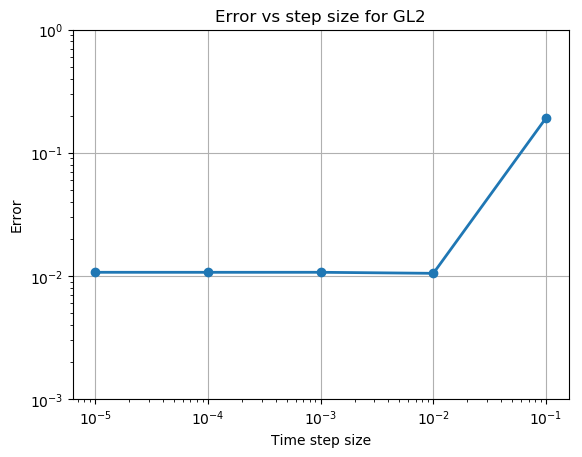

(0.001, 1.0)

In [29]:
plotError(step_size, err, title = "Error vs step size for GL2", xlabel = "Time step size")

## b) Solution by RK4 method

In [33]:
function rk4Stages(solution::Vector, A::Matrix, b::Vector, S::AbstractFloat,
    dt::AbstractFloat)

    k1 = autonomized_rhs(solution, A, b, S)
    k2 = autonomized_rhs(solution+dt/2*k1, A, b, S)
    k3 = autonomized_rhs(solution+dt/2*k2, A, b, S)
    k4 = autonomized_rhs(solution+dt*k3, A, b, S)
    return k1, k2, k3, k4
end

function stepRK4(solution::Vector, A::Matrix, b::Vector, S::AbstractFloat,
    dt::AbstractFloat)

    k1, k2, k3, k4 = rk4Stages(solution, A, b, S, dt)
    return solution + dt/6*(k1+2k2+2k3+k4)
end

function runRK4Iterations(xi0::Vector, A, b, S, dt, stop_time)

    xi = copy(xi0)
    current_time = 0.0
    @assert current_time < stop_time
    while !(isapprox(current_time - stop_time, 0.0, atol = dt/2))
        current_time += dt
        xi = stepRK4(xi, A, b, S, dt)
    end
    return xi
end

runRK4Iterations (generic function with 1 method)

In [37]:
step_size, err = getErrorVsStepSize(runRK4Iterations, A, b, S);

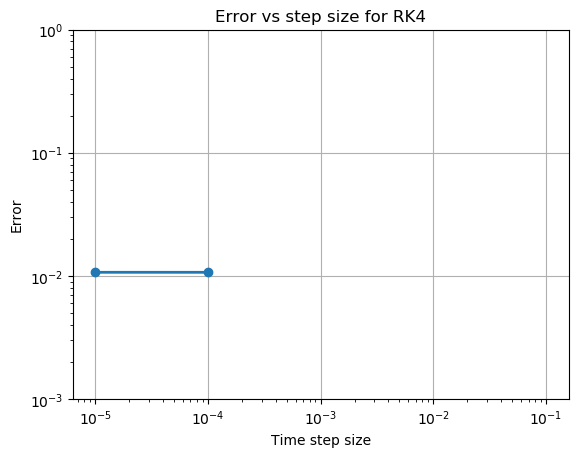

(0.001, 1.0)

In [38]:
plotError(step_size, err, title = "Error vs step size for RK4", xlabel = "Time step size")

## Difference between GL2 and RK4

We see that RK4 does not give a valid solution for time step size $dt = 10^{-3}, 10^{-2}, 10^{-1}$. This is because while GL2 is A-stable, RK4 is not A-stable. So we must choose the time step size small enough so that the RK4 scheme remains stable.

## c) Error vs. $S$ parameter

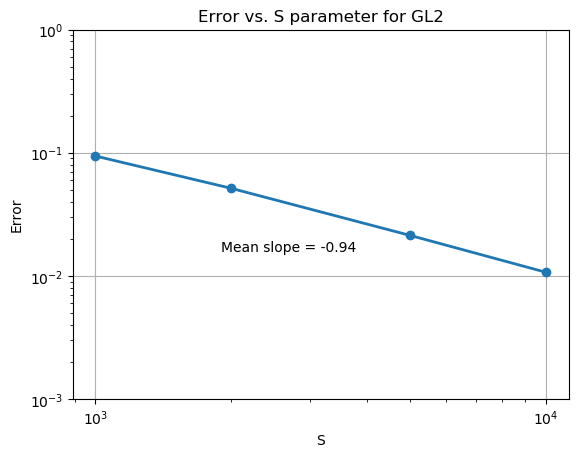

(0.001, 1.0)

In [39]:
function getErrorVsS(A, b, S)
    Slist = [1e3, 2e3, 5e3, 1e4]
    stop_time = 1.0
    # dt_list = [1e-2, 1e-2, 1e-2, 1e-3]
    dt = 1e-3
    err = zeros(length(Slist))
    analytical_solution = analyticalSolution(A,b)
    u0 = b/norm(b)
    xi0 = complex(vcat(u0, 0.0))
    for (idx,S) in enumerate(Slist)
        xi = runGL2Iterations(xi0, A, b, S, dt, stop_time)
        u = xi[1:end-1]
        err[idx] = getError(u,analytical_solution)
    end
    return Slist, err
end

Slist, err = getErrorVsS(A, b, S)
plotError(Slist, err, xlabel = "S", slope = true, title = "Error vs. S parameter for GL2")

## Dependence of error on $S$
From the above plot we can see that the error is approximately linearly proportional to the parameter $S$. Larger values of $S$ gives a more accurate solution. This is consistent with the expected behavior that the ODE approximates the solution to the linear system as $S \to \infty$